---
---

<h1><center><ins>Exercise Sheet 11</ins></center></h1>
<h2><center>Numerical Methods <br><br>

---
---

In [2]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from astropy.io import fits



## Exercise 1 — Periods in a Variable Star Light Curve & Aliasing

Stars typically exhibit differential rotation (because they are not solid), meaning that their rotational velocity changes as a function of latitude (i.e. rotation around the equator is faster than around the poles typically). 
One way to measure this differential rotation is by tracking darkspots on the surface of the star. The darkspots are areas, where the temperature of the star's surface is locally lower, i.e. the flux output will be lower as well.
Due to the rotation the total flux of the star will be temporarly dimmed, when the darkspot rotates into our line-of-sight. By recording the temporal change of the flux of star is called a Light Curve and we can estimate the stars's rotational velocity from it by assuming Keplerian rotation. (see e.g. https://hoys.space/lightcurve-of-the-week-358/ for an animation).
If there are multiple darkspots at different latitudes present on the star's surface, the recodered Light Curve will be a superposition of multiple sinusoids with different periods. 
Below you find a synthetic *Kepler-like* light curve of a spotted, differentially rotating star. The flux is the sum of three sinusoids plus some noise. The light curve is plotted below.

**A** Compute the one-sided power spectral density (PSD) using a FFT (you can use the build-in functions for FFT from numpy, but code your own function for the PSD) and find the three dominant rotations periods. Use the *find_peaks* function from *scipy.signal*. 
Plot the PSD and the peaks you found. What are the periods you found compared to the true ones?

**B** Compute the Nyquist frequency for the sampling, and **discuss** why this is important.

**C** Repeat **A** by assuming that you recorded the Light Curve only every $m$-th time. Use 8, 16 and 64 for m. What is happening to the PSD and the recovered periods?


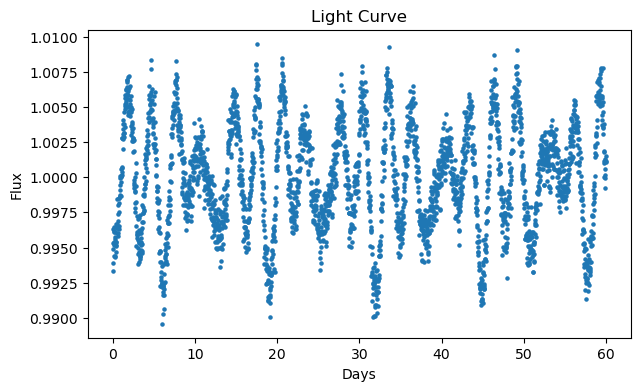

Periods found (days):
6.667
3.158
2.609


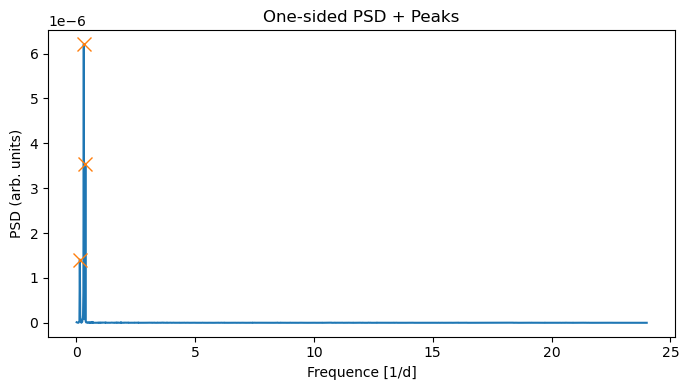

Sampling: dt = 0.020833 d
Samplingfrequency fs = 48.000 1/d
Nyquist-Frequency f_Nyq = 24.000 1/d
Corresponds to minimal periode P_min = 0.041667 d = 1.00 h

--- m = 8 ---
dt_m = 0.166667 d,  f_Nyq = 3.0000 1/d  (P_min = 0.333 d)
Periods (days):
  2.609
  3.158
  6.667


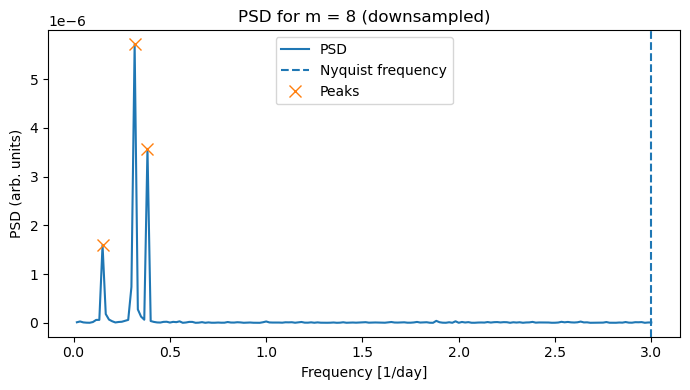


--- m = 16 ---
dt_m = 0.333333 d,  f_Nyq = 1.5000 1/d  (P_min = 0.667 d)
Periods (days):
  2.609
  3.158
  6.667


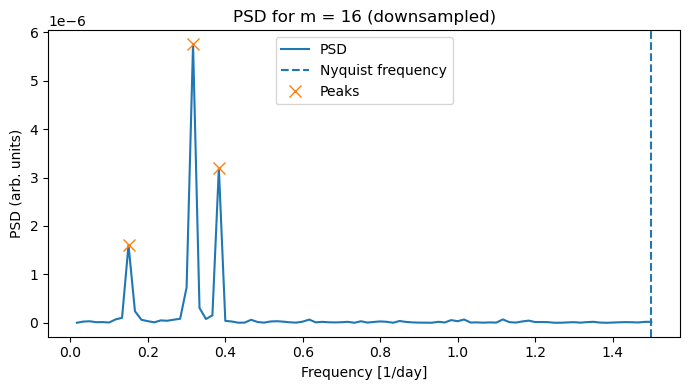


--- m = 64 ---
dt_m = 1.333333 d,  f_Nyq = 0.3750 1/d  (P_min = 2.667 d)
Periods (days):
  3.158
  6.667


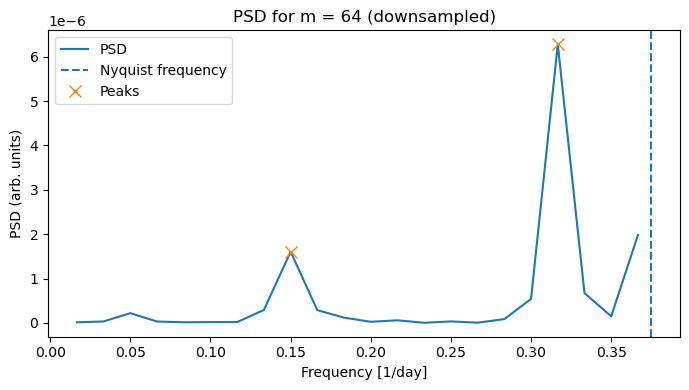

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from astropy.io import fits

# --- Synthetic light curve ---
#Erzeugung Zufallszahlengenerator mit fixem Seed 42 (zwecks Reproduzierbarkeit)
rng = np.random.default_rng(42)

# True periods (days)
#Wahre Periode P mit wahrer Amplitude A und wahrer Startphase phi (3 zufällig gewählte Werte zwischen 0 und 2pi), vorgegeben
#--> kann interpretiert werden als drei Flecken(gruppen) in verschiedenen Breiten, die Helligkeit modulieren
P_true = np.array([3.2, 2.6, 6.5])
A_true = np.array([0.004, 0.0025, 0.0018])
phi_true = rng.uniform(0, 2*np.pi, size=3)

# Cadence and time base
#dt: Zeitabstand zwischen Messpunkten. Soll 30min sein, in Tagen --> dt=30/60/24 ~ 0.02d
#T: gesamte Beobachtungszeit: 60 Tage
#t: Array mit Messzeitpunkten. t=0,dt,2dt,3dt,...

dt = 30.0 / 60.0 / 24.0  # 30 minutes in days
T = 60.0                 # total baseline in days
t = np.arange(0, T, dt)

# Red-ish noise via filtering white noise
#wn: erzeugen weißes Rauschen (normalverteilt mit Mittelwert 0 und Standardabweichung 0,001). Brauchen so viele Punkte wie Messzeitpunkte t --> t.size
wn = rng.normal(0, 0.001, size=t.size)

# Simple 1D smoothing kernel for colored noise
# erzeugen Filter, um weißes Rauschen zu rotem Rauschen zu transformieren
# Kernel dämpft schnelle Schwankungen
# Weißes Rauschen wird mit Kernel gefaltet --> rotes Rauschen
kernel = np.exp(-0.5*((np.arange(-10,11))/4.0)**2)
kernel /= kernel.sum()
red_noise = np.convolve(wn, kernel, mode='same')

# Signal
# Erzeugen Signal, start mit Nullarray

signal = np.zeros_like(t)

#Parallele Schleife über A, P und phi mit zip()
#Signal ist Summe aus drei Komponenten
for A, P, phi in zip(A_true, P_true, phi_true):
    signal += A * np.sin(2*np.pi*t/P + phi)

#Zusammensetzung der Messreihe aus Basisfluss (1.0), Signal, weißem Rauschen und rotem Rauschen
flux = 1.0 + signal + red_noise + wn

# --- Plot PSD ---
plt.figure(figsize=(7,4))
plt.scatter(t, flux, s=5)  # skip DC on log scale
plt.xlabel("Days")
plt.ylabel("Flux")
plt.title("Light Curve")
plt.show()

##############
#Part A: Compute one-sided PSD 
#Aufgabe: Mit FFT die drei Frequenzen f=1/Pi wiederfinden, die im Signal stecken.
# Tasks: 
# 1) FFT der Messreihe flux um die Frequenzen zu finden
# one-sided: Brauchen jede Frequenz nur einmal (nicht die mathematischen "Spiegelbilder"), weil das Signal reell ist. FFT erzeugt Peak bei +f und -f, 
# brauchen aber nur +f
# 2) Erzeugung PSD (Power Spectrum): Wie stark trägt Frequenz zur Variabilität des Signals bei?
# --> Leistung ist Betrag der Frequenz zum Quadrat (multipliziert mit Faktor 2, weil one-sided).
# Normierung mit 1/N² --> N Anzahl der Messpunkte
# 3) Peaks finden mit find_peaks
# 4) Plot PSD und peaks


# 1) FFT finden
# dazu Mittelwert entfernen, damit die Nullfrequenz nicht im Spektrum dominiert. 
# Erzeugen neue Zeitreihe mit Mittelwert=0
y = flux - np.mean(flux)

# One-sided FFT
N = len(y)
#Nutze rfft um nur +f zu bekommen
fft = np.fft.rfft(y)
#rfftfreq gibt Frequenzen zurück (Input N (Anzahl Messpunkte), dt (Abstand zwischen Messpunkten)). Frequenzen hat dann die Einheit 1/Tag
freq = np.fft.rfftfreq(N, d=dt)  # 1/days

# 2) Berechnung psd
psd = (2.0 / N**2) * np.abs(fft)**2

# Entfernung der Nullfrequenz (freq=0 --> Periode unendlich). 
# mask: True wenn freq>0, False sonst
mask = freq > 0
# f und p enthalten nur die Werte wo freq>0
f = freq[mask]
p = psd[mask]

# 3) Peaks finden 
# find_peakls sucht lokale Maxima in Zeitreihe p. "prominence" gibt an, wie stark der peak ist. 
# Nehme nur peaks, die mindestens 5% der maximalen power (np.max(p)) haben.
# Funktion liefert array peaks mit den Indizes der Peaks in der Zeitreihe und Zusatzinfos zu Höhe, Breite etc in "props"
peaks, props = find_peaks(p, prominence=np.max(p) * 0.05)

# Frequenzen wieder in Perioden umrechnen
peak_freqs = f[peaks]
peak_periods = 1.0 / peak_freqs

print("Periods found (days):")
for P in peak_periods:
    print(f"{P:.3f}")

# 4) Plot PSD + Peak-Markierungen
plt.figure(figsize=(7,4))
plt.plot(f, p)
plt.plot(peak_freqs, p[peaks], "x", markersize=10)
plt.xlabel("Frequence [1/d]")
plt.ylabel("PSD (arb. units)")
plt.title("One-sided PSD + Peaks")
plt.tight_layout()
plt.show()


##############
#Part B:  Compute the Nyquist frequency for the sampling
fs = 1.0 / dt
f_nyq = fs / 2.0
P_min = 1.0 / f_nyq

print(f"Sampling: dt = {dt:.6f} d")
print(f"Samplingfrequency fs = {fs:.3f} 1/d")
print(f"Nyquist-Frequency f_Nyq = {f_nyq:.3f} 1/d")
print(f"Corresponds to minimal periode P_min = {P_min:.6f} d = {P_min*24:.2f} h")

###############
#Part C
# Repeat A with different sampling rates

#Definiere Funktion mit Input 
# flux: Messreihe
# dt: Zeitabstand zwischen Messpunkten
# prominence: Für Auswahl der Peaks
# Output der Funktion:
# f: Frequencies
# p: PSD
# peaks_freqs: gefunden Frequenzen
# peaks_periods: gefunden Perioden

def one_sided_psd_peaks(flux, dt, prominence_frac=0.05):
    y = flux - np.mean(flux)
    N = len(y)
    fft = np.fft.rfft(y)
    freq = np.fft.rfftfreq(N, d=dt)
    psd = (2.0 / N**2) * np.abs(fft)**2 

    mask = freq > 0
    f = freq[mask]
    p = psd[mask]

    peaks, _ = find_peaks(p, prominence=np.max(p) * prominence_frac)
    peak_freqs = f[peaks]
    peak_periods = 1.0 / peak_freqs

    # Sortiere peaks nach Periode
    order = np.argsort(peak_periods)
    
    
    return f, p, peak_freqs[order], peak_periods[order]

## Wiederholung von A mit downsampling
# Faktoren für Downsampling ms
ms = [8, 16, 64]

for m in ms:

# Berechne neuen Zeitabstand zwischen Messpunkten dt_m
# Wähle nur die passenden Punkte aus der Messreihe aus
    dt_m = dt * m
    flux_m = flux[::m]  

    # PSD und Peaks berechnen
    f, p, pf, P = one_sided_psd_peaks(flux_m, dt_m, prominence_frac=0.05)

    # Nyquist-Frequenz berechnen
    f_nyq = 1.0 / (2.0 * dt_m)

    # Ausgabe der Ergebnisse
    print(f"\n--- m = {m} ---")
    print(f"dt_m = {dt_m:.6f} d,  f_Nyq = {f_nyq:.4f} 1/d  (P_min = {1/f_nyq:.3f} d)")
    print("Periods (days):")
    for val in P[:10]:
        print(f"  {val:.3f}")

    # Plotten der Ergebnisse
    plt.figure(figsize=(7, 4))
    plt.plot(f, p, label="PSD")
    plt.axvline(f_nyq, linestyle="--", label="Nyquist frequency")
    plt.plot(pf, np.interp(pf, f, p), "x", markersize=9, label="Peaks")

    plt.xlabel("Frequency [1/day]")
    plt.ylabel("PSD (arb. units)")
    plt.title(f"PSD for m = {m} (downsampled)")
    plt.legend()
    plt.tight_layout()
    plt.show()

### Notes for 1B (and C):

The Nyquist frequency is $f_c = \frac{1}{2*dt}$.

With dt=30min it follows that $f_c= 1/60 min = 1/24 = 0.0417 d$.

Thus the shortest Period that can be resolved is P=1/fc = 0.0417d ~1h. Signals with larger frequencies can not be resolved with this sampling. The three frequencies in the example are all below the Nyquist frequency and can be recovered.

If the sampling frequency is changed (in Part C), the Nyquist Frequency changes also. For m=64, the shortest Period that can be recovered is 2.66.. days, which is larger than the 2.6 days from the example. Thus there are only two frequencies that can be found by the programm and the one with P=2.6 days is missed (because the PSD gets to noisy). The "aliasing" gets important in that case (see Lecture Notes page 19). 



## Exercise 2 — Radial Velocity from FFT Cross-Correlation of Spectra

Below you see a real spectrum of the elliptical Galaxy NGC3522 taken from the SDSS survey (https://www.sdss.org/). This galaxy has an old stellar population and thus you see deep absorption lines coming from low-mass stars present in the galaxy.

**(A)** Ask your favourite AI to give you the wavelengths in air of the following lines: Ca H & K (H & K comes from the identification that Frauenhofer used when he studied the spectrum of the sun: https://en.wikipedia.org/wiki/Fraunhofer_lines), NaD (sodium doublet) and CaT (calcium triplet). Overplot the wavelength of those lines in the plot of the spectrum of NGC3522. Which formula now can give you very simply the redshift the galaxy?

One popular and perhaps a bit more sphosticated way to measure the redshift (or line-of-sight velocity) of a galaxy is to cross-correlate its spectrum with a template, or model spectrum, which does not contain any noise and where the absorption lines are at their known rest-frame wavelengths.

**(B)** Explain first very simply what cross-correlation is, and how we can measure the redshift from this. Explain also what this has to do with the Fourier Transform.

**(C)** Before you can cross-correlate the observed and modelled spectrum you need to convert the spacing between each recorded wavelength in your spectrum from linear to logarithmic. That means instead of $\lambda_{i+1}-\lambda_i=const.$, you need $\ln\lambda_{i+1}-\ln\lambda_i=const.$. Can you explain why that is? You can ask again your favourite AI if you wish (but please make sure you understand the answer ;). In the code below, you can see that the observed SDSS spectrum is already logarithmically re-binned and for the model spectrum, I am using the function *log_rebin* to convert the wavelength sampling from linear to logarithmic. Hence, there is no further action needed from your side for the next exercise.

**(D)** Implement your own cross correlation function by using build-in FFT methods. Plot the computed cross correlation function versus the lag in km/s. (**Hint**: the pixel spacing in Angström per pixel of both the SDSS and model spectrum are constant in $\ln\lambda$, and the pixel spacing in km/s is stored in the variable *velscale*). Find the redshift you calculate from your cross-correlated signal (**Hint**: the redshift is now: np.exp(**[your solution in km/s]**/c)-1). How does your calculated redshift compare to the one provided by SDSS (**Hint**: it is stored in the variable *redshift_0*) ? For the template spectrum you can use the one provided in the file *Mbi0.30Zp0.40T13.5000_iTp0.00_baseFe.fits*. Below you will find some code to handle the template, which you just need to run.


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from astropy.io import fits

# these function convert the wavelengths of the SDSS spectrum (which are measured in vacuum) to wavelength of the model spectrum (which are given in air)
def _wave_convert(lam):
    """
    Convert between vacuum and air wavelengths using
    equation (1) of Ciddor 1996, Applied Optics 35, 1566
        http://doi.org/10.1364/AO.35.001566

    :param lam - Wavelength in Angstroms
    :return: conversion factor

    """
    lam = np.asarray(lam)
    sigma2 = (1e4/lam)**2
    fact = 1 + 5.792105e-2/(238.0185 - sigma2) + 1.67917e-3/(57.362 - sigma2)

    return fact

###############################################################################


def vac_to_air(lam_vac):
    """
    Convert vacuum to air wavelengths

    :param lam_vac - Wavelength in Angstroms
    :return: lam_air - Wavelength in Angstroms

    """
    return lam_vac/_wave_convert(lam_vac)

### This opens the SDSS spectrum of NGC 3522 (important thing here is that the variable *lam_gal* are the stored wavelengths and *galaxy* the flux recorded at every wavelength)
#### you can add part **A** in the code below

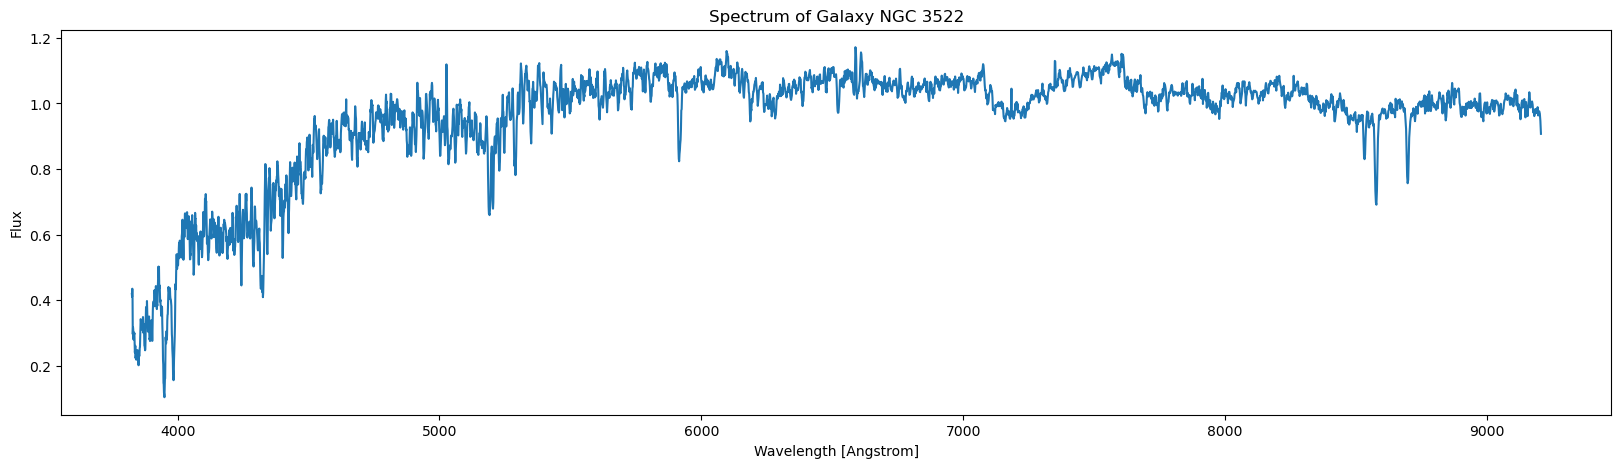

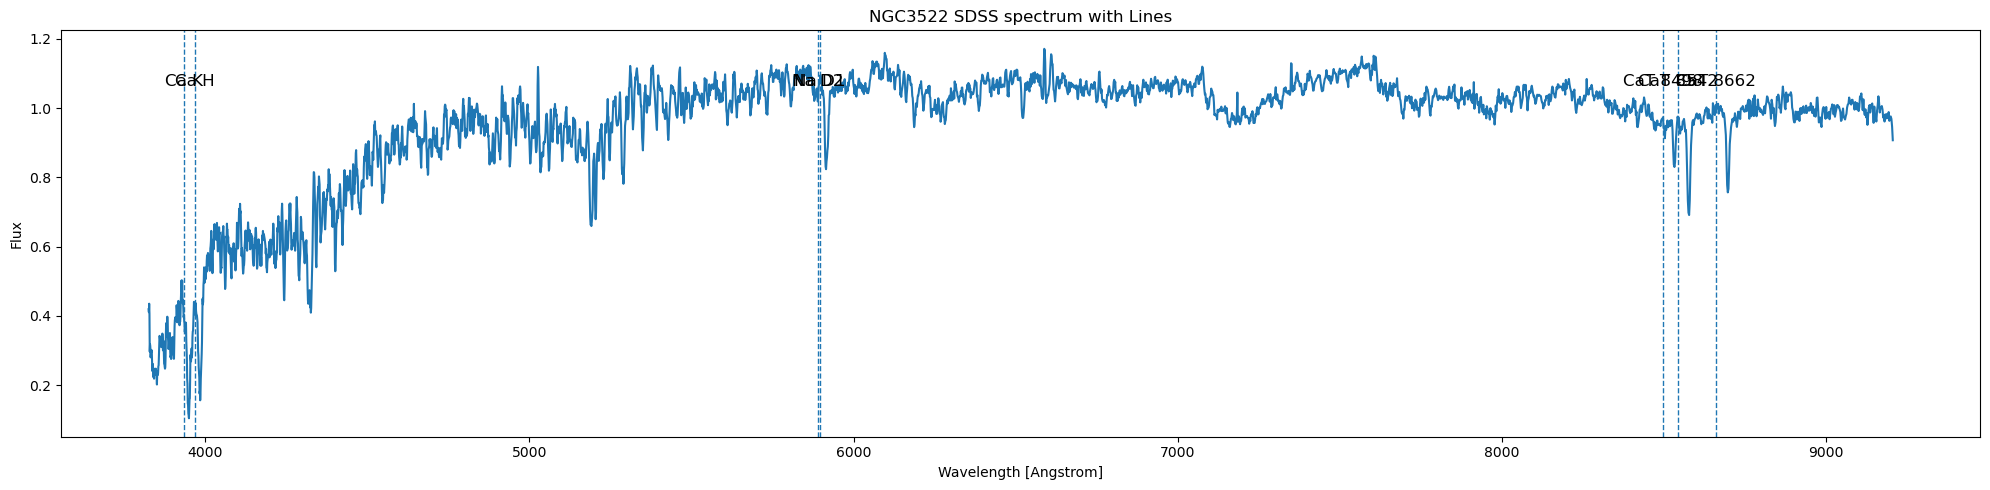

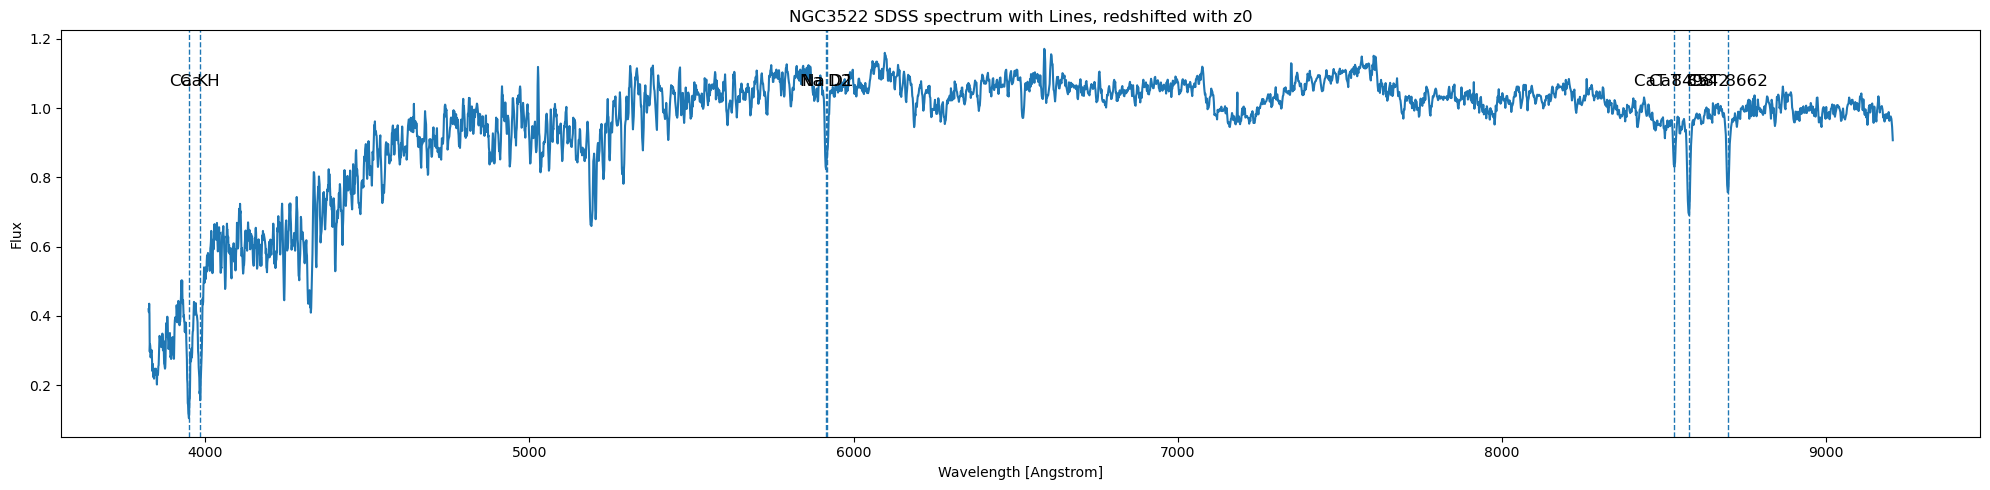

In [5]:
filename = 'NGC3522_SDSS_DR18.fits'
# hab "memmap=False" hinzugefügt, weil das sonst Probleme gibt, den Rest des codes in Jupyter Lite auszuführen
# Die Datei soll normal in den Arbeitsspeicher gelesen werden, nicht per Memory-Mapping
hdu = fits.open(filename, memmap=False) 

t = hdu['COADD'].data
redshift_0 = hdu['SPECOBJ'].data['z'].item()       # SDSS redshift estimate

galaxy = t['flux']/np.median(t['flux'])     # Normalize spectrum to avoid numerical issues
ln_lam_gal = t['loglam']*np.log(10)         # Convert lg --> ln
lam_gal = np.exp(ln_lam_gal)                # Wavelength in Angstroms (log sampled)
lam_gal = vac_to_air(lam_gal)

c = 299792.458  # speed of light in km/s
d_ln_lam_gal = (ln_lam_gal[-1] - ln_lam_gal[0])/(ln_lam_gal.size - 1)  # Use full lam range for accuracy
velscale = c*d_ln_lam_gal                   # Velocity scale in km/s per pixel (eq.8 of Cappellari 2017)
dlam_gal = np.gradient(lam_gal)             # Size of every pixel in Angstroms
wdisp = t['wdisp']                          # Instrumental dispersion of every pixel, in pixels units
fwhm_gal = 2.355*wdisp*dlam_gal             # Resolution FWHM of every pixel, in Angstroms

plt.figure(figsize=(20,5))
plt.plot(lam_gal, galaxy)
plt.xlabel("Wavelength [Angstrom]")
plt.ylabel("Flux")
plt.title("Spectrum of Galaxy NGC 3522")

###########
#Part A
#Wellenlänge von K, H, D1,D2, Cx3 in Angstrom
lines_air = {
    "Ca K": 3933.663,
    "Ca H": 3968.468,
    "Na D2": 5889.950,
    "Na D1": 5895.924,
    "CaT 8498": 8498.02,
    "CaT 8542": 8542.09,
    "CaT 8662": 8662.14,
}

#Plotte Linien in Spektrum

plt.figure(figsize=(20,5))
plt.plot(lam_gal, galaxy)

y_top = np.nanpercentile(galaxy, 95)  # sinnvolle y-Position für Labels

for name, lam0 in lines_air.items():
    plt.axvline(lam0, ls="--", lw=1)
    plt.text(lam0, y_top, name, va="top", ha="center", fontsize=12)

plt.xlabel("Wavelength [Angstrom]")
plt.ylabel("Flux")
plt.title("NGC3522 SDSS spectrum with Lines")
plt.tight_layout()
plt.show()

#Plotte Linien in Spektrum mit Rotverschiebung

plt.figure(figsize=(20,5))
plt.plot(lam_gal, galaxy)

y_top = np.nanpercentile(galaxy, 95)  # sinnvolle y-Position für Labels

for name, lam0 in lines_air.items():
    lam_obs = lam0 * (1.0 + redshift_0)  # Position der Linie mit Rotverschiebung
    plt.axvline(lam_obs, ls="--", lw=1)
    plt.text(lam_obs, y_top, name, va="top", ha="center", fontsize=12)

plt.xlabel("Wavelength [Angstrom]")
plt.ylabel("Flux")
plt.title("NGC3522 SDSS spectrum with Lines, redshifted with z0")
plt.tight_layout()
plt.show()

### Notes for 2A:

redshift z = (observed wavelength / laboratory wavelength) -1 

Thus: $z=\frac{\lambda_{obs}-\lambda_0}{\lambda_0}$

### Notes for 2B:

Question: Explain first very simply what cross-correlation is, and how we can measure the redshift from this. Explain also what this has to do with the Fourier Transform.

Answer:

Cross-correlation measures the similarity between two spectra as a function of their relative shift. When shifting a template spectrum over the real spectrum, we will get maximum correlation, when the absorption lines are aligned. In that position, the shift corresponds to the redshift of the galaxay. To do this, we would have to do caculations of Order N². But in frequency-space 
it is much easier. See Lecture Notes and the Correlation Theorem on page 13: "Correlation Theorem – Multiplying the Fourier transform of one function by the complex conjugate of the Fourier transform of the other gives the Fourier transform of their correlation". According to the Correlation Theorem, we can computed the correlation efficiently by multiplying the Fourier transform of one spectrum with the complex conjugate of the Fourier transform of the other and then transforming back.

### Notes for 2C:

Question: Why convert the spacing between each recorded wavelength in your spectrum from linear to logarithmic?

Answer: Before cross-correlation, the spectra have to be binned evenly spaced in ln $\lambda$. The reason is, that the redshift is connected to the wavelength with multiplication: 

$$
\lambda_{obs} = (1+z) \lambda_0
$$

Every line gets shifted by the same factor, but the absolute shift is different for different wavelengths. With z=0.01 i.e a line at 4000 Å gets shifted to 4040 Å, but a line at 8000 Å gets shifted to 8080 Å. When cross-correlating, we shift the template with a fixes pixel rate. But this will not work, if the lines in the real spectra are shifted with different absolute valies. 

Taking the logarithm, this changes to:

$$
ln \lambda_{obs} = ln (1+z) + ln \lambda_0
$$

Now the connection between redshift and wavelength is additive. And the lines shift with the same value. A constant shift in pixels corresponds to a constant velocity, which makes the cross-correlation physically meaningful.

In our case, this has already be done with the line

ln_lam_gal = t['loglam']*np.log(10) 

in the first block of code.

### This function converts a constant linear wavelength sampling to a constant logarithmic wavelength sampling (you do not need do understand the details of this)

In [6]:
def log_rebin(lam, spec, velscale=None, oversample=1, flux=False):
    lam, spec = np.asarray(lam, dtype=float), np.asarray(spec, dtype=float)
    assert np.all(np.diff(lam) > 0), '`lam` must be monotonically increasing'
    n = len(spec)
    assert lam.size in [2, n], "`lam` must be either a 2-elements range or a vector with the length of `spec`"

    if lam.size == 2:
        dlam = np.diff(lam)/(n - 1)             # Assume constant dlam
        lim = lam + [-0.5, 0.5]*dlam
        borders = np.linspace(*lim, n + 1)
    else:
        lim = 1.5*lam[[0, -1]] - 0.5*lam[[1, -2]]
        borders = np.hstack([lim[0], (lam[1:] + lam[:-1])/2, lim[1]])
        dlam = np.diff(borders)

    ln_lim = np.log(lim)
    c = 299792.458                          # Speed of light in km/s

    if velscale is None:
        m = int(n*oversample)               # Number of output elements
        velscale = c*np.diff(ln_lim)/m      # Only for output (eq. 8 of Cappellari 2017, MNRAS)
        velscale = velscale.item()          # Make velscale a scalar
    else:
        ln_scale = velscale/c
        m = int(np.diff(ln_lim)/ln_scale)   # Number of output pixels

    newBorders = np.exp(ln_lim[0] + velscale/c*np.arange(m + 1))

    if lam.size == 2:
        k = ((newBorders - lim[0])/dlam).clip(0, n-1).astype(int)
    else:
        k = (np.searchsorted(borders, newBorders) - 1).clip(0, n-1)

    specNew = np.add.reduceat((spec.T*dlam).T, k)[:-1]    # Do analytic integral of step function
    specNew.T[...] *= np.diff(k) > 0                      # fix for design flaw of reduceat()
    specNew.T[...] += np.diff(((newBorders - borders[k]))*spec[k].T)    # Add to 1st dimension

    if not flux:
        specNew.T[...] /= np.diff(newBorders)   # Divide 1st dimension

    # Output np.log(wavelength): natural log of geometric mean
    ln_lam = 0.5*np.log(newBorders[1:]*newBorders[:-1])

    return specNew, ln_lam, velscale

### This opens and prepares the **model** spectrum (important thing here is that the variable *lam_gal* are the stored wavelengths and *model* the flux recorded at every wavelength)

<ipython-input-6-81eeb9045dcb>:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  m = int(np.diff(ln_lim)/ln_scale)   # Number of output pixels


Text(0.5, 1.0, 'Model Spectrum of an old, metal-rich stellar population')

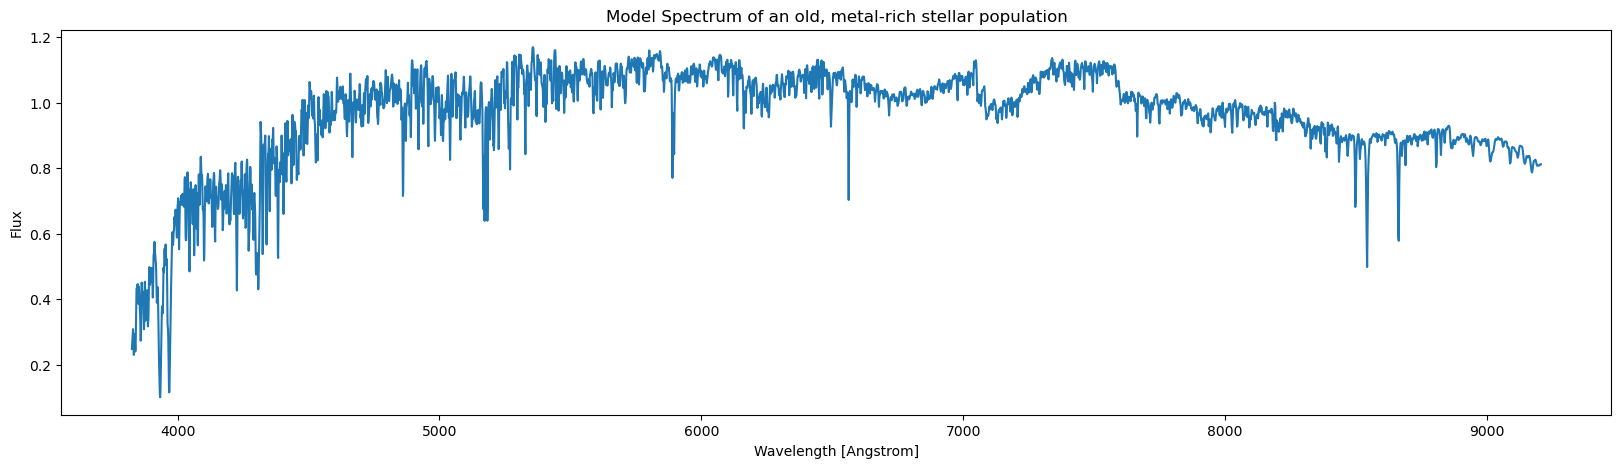

In [7]:
# hab "memmap=False" hinzugefügt, weil das sonst Probleme gibt, den Rest des codes in Jupyter Lite auszuführen
# Die Datei soll normal in den Arbeitsspeicher gelesen werden, nicht per Memory-Mapping
hdu=fits.open('Ech1.30Zm0.40T14.1254_iPp0.00_baseFe.fits', memmap=False)
model=hdu[0].data
wave, fwhm_a = np.loadtxt("emiles_spectral_resolution.dat" ,
                usecols=(0, 1),
                unpack=True,
            )
wave_mask = (wave < lam_gal[-1]) & (wave > lam_gal[0])
wave=wave[wave_mask]
model=model[wave_mask]
model/=np.nanmedian(model)
model, ln_lam_model, _ =log_rebin(np.array([lam_gal[0],lam_gal[-1]]), model, velscale)
wave = np.exp(ln_lam_model)
model=np.interp(lam_gal,wave,model) ###final flux of your modelled spectrum, use this for cross-correlation

plt.figure(figsize=(20,5))
plt.plot(lam_gal, model)
plt.xlabel("Wavelength [Angstrom]")
plt.ylabel("Flux")
plt.title("Model Spectrum of an old, metal-rich stellar population")


=== FFT Cross-Correlation Result ===
velscale: 69.029784 km/s per pixel
Peak lag: 18 pixels
Best v:  1242.54 km/s
z (CCF): 0.004153
z (SDSS): 0.004018
Delta z:  +1.352419e-04


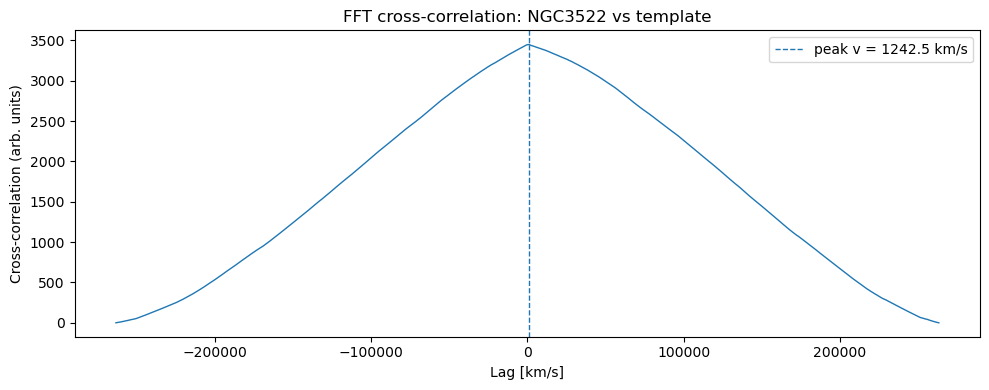

In [9]:


import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.signal import find_peaks

####
# Part D
# Task: Eigene Funktion für cross-correlation schreiben und Rotverschiebung berechnen

# -----------------------------
# FFT cross-correlation 
# Input: 2 Spektren a and b
# Output: cross-correlation Funktion (ccf) und die jeweils zugehörige Verschiebung in Pixeln (lags_pix)
# -----------------------------
def fft_cross_correlation(a, b):
    """
    Linear cross-correlation via FFT:
      corr = ifft( FFT(a) * conj(FFT(b)) )
    Returns:
      ccf (length 2N-1), lags_pix (-(N-1) ... +(N-1))
    """
# Spektren in numpy-arrays transformieren 
    a = np.asarray(a, float)
    b = np.asarray(b, float)

# Cross-correlation braucht 2N-1 Punkte

    n = a.size
    n_corr = 2 * n - 1
    
# FFT ist am schnellsten mit 2er-Potenzen-->  runden N auf auf nächstgrößte 2er-Potenz  
    nfft = int(2 ** np.ceil(np.log2(n_corr)))  
 
# Berechnen FFT    
    fa = np.fft.rfft(a, nfft)
    fb = np.fft.rfft(b, nfft)

# Berechnen cross-correlation
# conj(b) --> b komplex konjugiert
# irfft --> Rücktransformation in Realraum    
    cc = np.fft.irfft(fa * np.conj(fb), nfft)

# Nullverschiebung (Verschiebung um 0 pixel) in die Mitte (Standardoutput der Funktion ist am Anfang). fftshift() macht das
    cc = np.fft.fftshift(cc)

# array mit den physikalisch sinnvollen Lags -(n-1) ... + (n-1) erzeugen
# (haben mehr Verschiebungen gemacht als physikalisch sinnvoll, wegen aufrunden auf 2er Potenz)    
# Aber bei n Punkten pro Spektrum machen nur Verschiebungen Sinn, wo man von -n-1 Pixel bis n Pixel gegeneinander verschiebt    
    lags_pix = np.arange(-(n - 1), n)

# Aus dem FFT-Array den passenden Teil der Kreuzkorrelation ausschneiden
# Bei index N/2 liegt die Nullverschiebung (um 0 pixel). Brauchen zuerst index dieses Mittelpunkts
    center = nfft // 2

# Jetzt nehmen wir Ausschnitt der cross-correlation um diesen Mittelpunkt herum    
    ccf = cc[center - (n - 1) : center + n]
 
    return ccf, lags_pix


# ============================================================
# (D) Cross-correlation via FFT; lag -> km/s; km/s -> z
# ============================================================

# Durchführung cross correlation. "galaxy" (reales Spektrum), "model" (Modellspektrum)
#( Hinweis: Zuerst die Codeboxen oben laufen lassen)

ccf, lags_pix = fft_cross_correlation(galaxy, model)

# Umwandlung der Verschiebung von Pixeln in km/s

lags_kms = lags_pix * velscale

# Wo liegt das Maximum der CC-Funktion?
imax = int(np.argmax(ccf))

# Welche Verschiebung (in km/s) ist das?
v_best = float(lags_kms[imax])

# Umrechnung in Rotverschiebung
z_best = float(np.exp(v_best / c) - 1.0)

print("\n=== FFT Cross-Correlation Result ===")

print(f"velscale: {velscale:.6f} km/s per pixel")
print(f"Peak lag: {lags_pix[imax]} pixels")
print(f"Best v:  {v_best:.2f} km/s")
print(f"z (CCF): {z_best:.6f}")
print(f"z (SDSS): {redshift_0:.6f}")
print(f"Delta z:  {z_best - redshift_0:+.6e}")

plt.figure(figsize=(10, 4))
plt.plot(lags_kms, ccf, lw=1)
plt.axvline(v_best, ls="--", lw=1, label=f"peak v = {v_best:.1f} km/s")
plt.xlabel("Lag [km/s]")
plt.ylabel("Cross-correlation (arb. units)")
plt.title("FFT cross-correlation: NGC3522 vs template")
plt.legend()
plt.tight_layout()
plt.show()


## Exercise 3 — The power of FFT in 2D image convolutions

In astronomy we are (de)convolving images all the time with, for example, the Point Spread Function (PSF). This would not be possible without the Fast Fourier Transform (FFT) and in this exercise we want to explore that a bit more.

**(A)** To get started write a simple function that returns you an image (2D array) of a simulated star field with infinitely sharp stars (i.e. Delta-function-like stars with no PSF/blurring effects). The function should take the size of the desired image as an argument (make it a square image for simplicity). The stars should be randomly distributed in the field-of-view with random magnitudes. Plot the resulting image for an image size of 128 pixels using *imshow* from *matpotlib*.

**(B)** Now we want to blurr out these image with the PSF (as we would observe them with a telescope). This processes is called *convolution* and the PSF would be our convolution *kernel*, which means that basically for each pixel in your simulated star field image, you apply a blurring, or spreading out of the flux of the stars across neighbouring pixels. The kernel describes in which way this spreading out is done. Write a function for the convolution kernel, i.e. the PSF. Assume that the PSF is Gaussian. Plot the resulting PSF assuming a kernel size of 21 pixels and a FWHM of 2.5 pixels.

**(C)** Doing convolution in image (or pixel) space is not very efficient. Luckly, doing a convolution in Fourier Space becomes easy, since the convolution reduces to a simple multiplication of the Fourer Transform of the image and the kernel. We then arrive back at the real blurred (PSF-convolved) image by calculating the inverse of the Fourier Transform. Implement now your **own algorithm** for FFT and its inverse. Convolve the image from **(A)** with the PSF from **(B)** and plot the new blurred image.

**HINT** Consider the following steps for **(C)**:

*1)* Implement the FFT algorithm for a 1D signal.

*2)* Write a function that calculates the inverse FFT. This function will use the forward FFT (think about the symmetries between discussed in the lecture as your signal only has a real part)

*3)* Calculating the 2D FFT is the same as first calculating 1D FFT along the rows and then along the columns of the image.

*4)* Before you can multiply the FFT of the image and the kernel you need to pad the PSF kernel with zeros to match the image size.

*5)* If you are spending more than 1hr on part **C** alone you may use your favourite AI to help you implement the code, but make sure you can explain/understand the steps that it is doing.

**(D)** Now we want to test the speed of your FFT convolution algorithm versus the **build-in** FFT convolution from *scipy.signal* called *fftconvolve* as well as the naive discrete convolution *convolve2d*. For this write a loop for varying image sizes. Each time double the number of pixels from **(A)**. Do this for times (or less if you have to wait for hours). For each loop time the three convolution functions using *time.time()* (build-in python package). Make a plot of computational time (log-scaled y-axis) vs. number of pixels in the image (x-axis) for all three functions. Who is the winner? How does this compare to the theoretical computational complexity of using FFT and the naive discrete convolution?

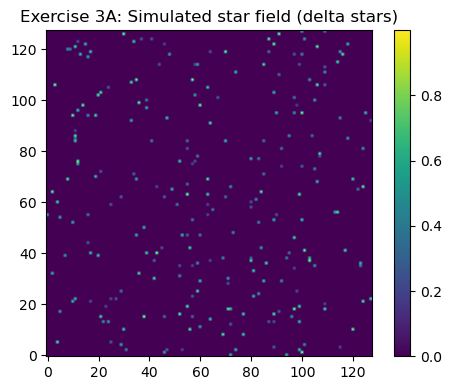

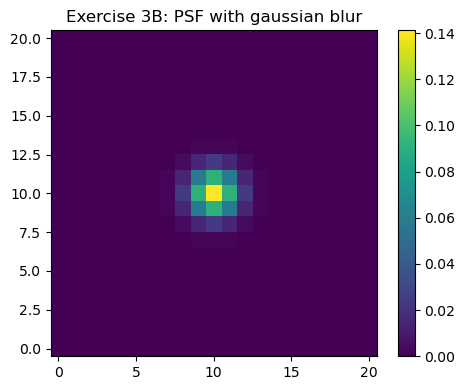

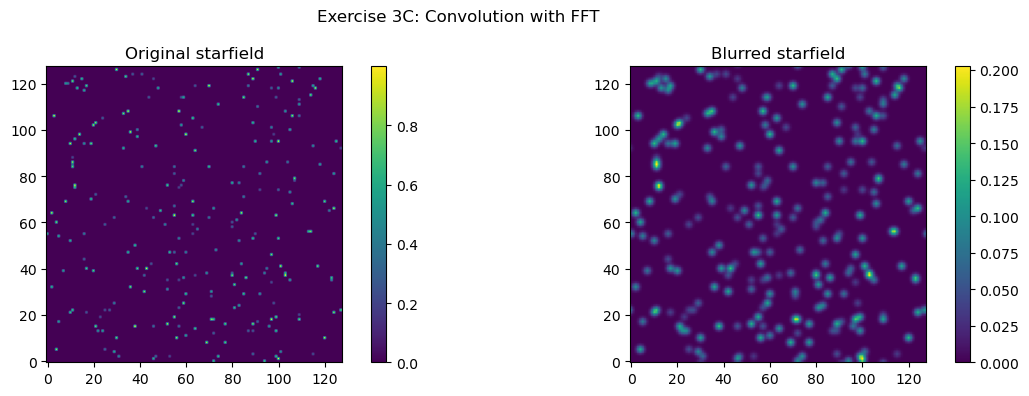

N= 128  ownFFT=1.7560s   fftconvolve=0.0010s   convolve2d=0.0190s
N= 256  ownFFT=7.2470s   fftconvolve=0.0030s   convolve2d=0.0780s
N= 512  ownFFT=29.5650s   fftconvolve=0.0130s   convolve2d=0.3080s
N=1024  ownFFT=118.2490s   fftconvolve=0.0580s   convolve2d=1.2450s


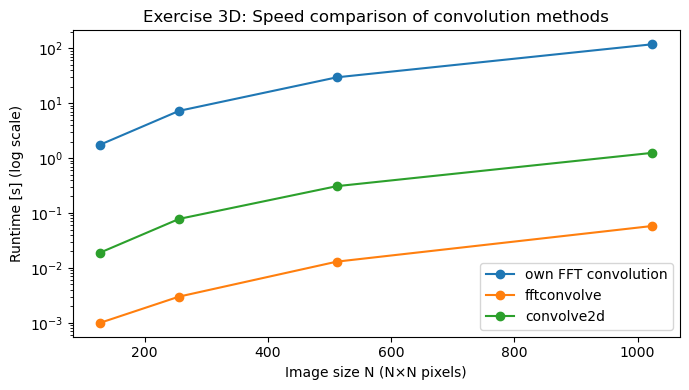


Winner at largest N: scipy fftconvolve


In [84]:
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.signal import fftconvolve, convolve2d

############
# Part A: Synthetisches Sternfeld
# Erzeuge Bild mit Sternen, 128 Pixel, Sterne zufällig verteilt mit Helligkeit in flux_range

def make_star_field(n, n_stars, seed, flux_range):

    
    rng = np.random.default_rng(seed)
    img = np.zeros((n, n), dtype=float)

    xs = rng.integers(0, n, size=n_stars)
    ys = rng.integers(0, n, size=n_stars)
    fs = rng.uniform(flux_range[0], flux_range[1], size=n_stars)

    img[ys, xs] += fs
    return img

N = 128
n_stars=250
seed=42
flux_range=(0.2,1.0)

img = make_star_field(N, n_stars, seed, flux_range)


plt.figure(figsize=(5, 4))
plt.imshow(img, origin="lower")
plt.title("Exercise 3A: Simulated star field (delta stars)")
plt.colorbar()
plt.tight_layout()
plt.show()

############
# Part B: Gaussian PSF kernel
# Bildgröße: 21 x 21 pixel

def gaussian_psf(size=21, fwhm=2.5):
 
# Standardabweichung aus Gaussfunktion 
# Halbwertsbreite FWHM = 2 * Wurzel (2 ln 2) * sigma
# FWHM laut Angabe = 2.5    
    
    sigma = fwhm / (2.0 * np.sqrt(2.0 * np.log(2.0)))

# Koordinatengitter (x,y) erzeugen
# Mittelpunkt mit ganzzahliger Division (//)    
    center = size // 2

    psf = np.zeros((size, size))

    for i in range(size):        # y-Richtung (Zeilen)
        for j in range(size):    # x-Richtung (Spalten)

            x = j - center
            y = i - center

# PSF berechnen mit Formel für 2D Gauss-Normalverteilung: g(x,y)=exp(-(x^2 + y^2)/2sigma)           
            psf[i, j] = np.exp(-(x**2 + y**2) / (2.0 * sigma**2))

# PSF normieren (damit Summe über alle Werte psf(x,y) = 1   
    psf = psf/psf.sum()
    return psf


psf = gaussian_psf(size=21, fwhm=2.5)
plt.figure(figsize=(5, 4))
plt.imshow(psf, origin="lower")
plt.title("Exercise 3B: PSF with gaussian blur")
plt.colorbar()
plt.tight_layout()
plt.show()


############
# Part C: Bild mit PSF falten


def fft1d(x):
#  1D FFT-Algorithmus wie in Lecture Notes ab Seite 28

# Input in komplexes array umwandeln: Länge N des Signals bestimmen (Anzahl der Datenpunkte)
# N muss 2er Potenz sein, damit Algorithmus funktioniert    
    
    x = np.asarray(x, dtype=complex)
    N = x.size
    
# FFT von Länge 1 ist das Signal selbst, gleich direkt wieder aussteigen    
    if N == 1:
        return x
    
    if N % 2 != 0:
        raise ValueError("fft1d: length must be a power of 2")
        
# Zerlegung in gerade und ungerade Indizes
# [::2] nimmt alle geraden Indizes
# [1::2] nimmt alle ungeraden Indizies    
# Wird rekursiv berechnet
    
    X_even = fft1d(x[::2])
    X_odd  = fft1d(x[1::2])

# Berechnung der Faktoren W (Lecture Notes p 31)    
# Hinweis: mit einem "j" nach einer Zahl weiß Python, dass es eine komplexe Zahl sein soll
 
    k = np.arange(N // 2) # Array erzeugen mit [0,1,2,..., N/2]
    W = np.exp(-2j * np.pi * k / N)

# Zusammensetzen der FFT    
    
    top = X_even + W * X_odd
    bot = X_even - W * X_odd
    X=np.concatenate([top, bot])
    return X

def ifft1d(X):
# Inverse FFT (eindimensional), folgt aus Symmetrieeigenschaften:
# iFFT(X)=1/N * konjugierte FFT (konjugiertem(X))    
    X = np.asarray(X, dtype=complex)
    N = X.size
    return np.conjugate(fft1d(np.conjugate(X))) / N



def fft2d(a):
#2D FFT: Zuerst 1D FFT entlang Spalten, dann 1D FFT entlang Reihen
    a = np.asarray(a, dtype=complex)
    H, W = a.shape

    tmp = np.zeros((H, W), dtype=complex)
    for i in range(H):
        tmp[i, :] = fft1d(a[i, :])

    out = np.zeros((H, W), dtype=complex)
    for j in range(W):
        out[:, j] = fft1d(tmp[:, j])

    return out

#Inverse 2D FFT: Zuerst inverse 1D FFT entlang Spalten, dann inverse 1D FFT entlang Reihen
def ifft2d(A):
   
    A = np.asarray(A, dtype=complex)
    H, W = A.shape

    tmp = np.zeros((H, W), dtype=complex)
    for i in range(H):
        tmp[i, :] = ifft1d(A[i, :])

    out = np.zeros((H, W), dtype=complex)
    for j in range(W):
        out[:, j] = ifft1d(tmp[:, j])

    return out

def pad_psf_to_image(psf, shape):
# PSF mit Nullen auffüllen, damit es zum Bild passt; dann Zentrum von PSF auf (0,0) verschieben    
   
    H, W = shape
    kh, kw = psf.shape
    if kh > H or kw > W:
        raise ValueError("PSF must be smaller than the image.")

    psf_pad = np.zeros((H, W), dtype=float)

    # PSF in die Mitte einsetzen
    y0 = H//2 - kh//2
    x0 = W//2 - kw//2
    psf_pad[y0:y0+kh, x0:x0+kw] = psf

    # Zentrum -> (0,0) verschieben
    psf_pad = np.fft.ifftshift(psf_pad)
    return psf_pad

def convolve_fft(img, psf):
# Faltung mit FFT
    
    img = np.asarray(img, float)
    H, W = img.shape

    # 1) PSF auf Bildgröße padden 
    psf_pad = pad_psf_to_image(psf, (H, W))

    # 2) FFT durchführen
    F_img = fft2d(img)
    F_psf = fft2d(psf_pad)

    # 3) Multiplikation im Fourier-Raum
    F_blur = F_img * F_psf

    # 4) zurück in Realraum transformieren
    blur = ifft2d(F_blur).real
    return blur


blurred = convolve_fft(img, psf)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.imshow(img, origin="lower")
plt.title("Original starfield")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(blurred, origin="lower")
plt.title("Blurred starfield")
plt.colorbar()

plt.suptitle("Exercise 3C: Convolution with FFT")
plt.tight_layout()
plt.show()

############
# Part D: Speed Test
#
# Vergleiche:
# 1) eigene FFT-Faltung: convolve_fft
# 2) scipy.signal.fftconvolve
# 3) scipy.signal.convolve2d 
#
# Vorgabe: Bildgrößen variieren, jedes Mal Pixelzahl verdoppeln (N -> 2N -> 4N ...)
# Zeiten messen mit time.time()
# Plot: Laufzeit (log y) vs Bildgröße (x) für alle drei

# Anzahl der Verdoppelungen
n_doublings = 4

sizes = []
t_own = []
t_fftconv = []
t_naive = []

# Startgröße aus Part A
N0 = N

for i in range(n_doublings):
    
    #Bildgröße verdoppeln    
    n_img = N0 * (2 ** i)

    #Anzahl Sterne grob skalieren
    n_stars=int(n_stars * (n_img / N0))
    
    # seed und flux_range aus Part A    
    seed=42
    flux_range=(0.2,1.0)
    
    # Sternfeld für diese Größe erzeugen 
    
    img_i = make_star_field(n_img, n_stars, seed, flux_range)

    # PSF bleibt gleich groß (21x21)
    psf_i = psf

    # 1) Eigene FFT-Faltung
    t0 = time.time()
    _ = convolve_fft(img_i, psf_i)
    t1 = time.time()
    t_own.append(t1 - t0)

    # 2) scipy.signal.fftconvolve 
    t0 = time.time()
    _ = fftconvolve(img_i, psf_i, mode="same")
    t1 = time.time()
    t_fftconv.append(t1 - t0)

    # 3) scipy.signal.convolve2d 
    t0 = time.time()
    _ = convolve2d(img_i, psf_i, mode="same", boundary="fill", fillvalue=0.0)
    t1 = time.time()
    t_naive.append(t1 - t0)

    sizes.append(n_img)

    print(f"N={n_img:4d}  ownFFT={t_own[-1]:.4f}s   fftconvolve={t_fftconv[-1]:.4f}s   convolve2d={t_naive[-1]:.4f}s")

# Plot: Laufzeit vs Bildgröße
plt.figure(figsize=(7, 4))
plt.plot(sizes, t_own, marker="o", label="own FFT convolution")
plt.plot(sizes, t_fftconv, marker="o", label="fftconvolve")
plt.plot(sizes, t_naive, marker="o", label="convolve2d")

plt.yscale("log")
plt.xlabel("Image size N (N×N pixels)")
plt.ylabel("Runtime [s] (log scale)")
plt.title("Exercise 3D: Speed comparison of convolution methods")
plt.legend()
plt.tight_layout()
plt.show()

# Auswertung
# Welche Methode war bei der größten Bildgröße am besten?
# mit Index "-1" auf letzten Eintrag in Liste zugreifen (=größtes Bild)
# Wo steht die kürzeste Zeit?
i_best = np.argmin([t_own[-1], t_fftconv[-1], t_naive[-1]])
methods = ["own FFT", "scipy fftconvolve", "naive convolve2d"]
print("\nWinner at largest N:", methods[i_best])



### Notes for 3D:

The naive convolution (convolve2d) scales approximately as  O(N²K²) because for every pixel (N²) a pixel of the Kernel (K²) has to be evaluated. The FFT methods scale with O(N²logN) - see Lecture Notes page 27. FFT methods will outperform the others for large N - as they do in the example; my own algorithm would also be faster, if implemented in a more professional way that optimizes runtime (I tried to optimize the code for my own understanding and readability)
